# VAE on 2d data

Рассмотрим модель вариационного автокодировщика для двумерного нормального распределения

In [2]:
from dgm_utils import train_model, plot_training_curves
from dgm_utils import visualize_2d_data, visualize_2d_samples
from dgm_utils import show_samples, visualize_images, load_pickle

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data

USE_CUDA = torch.cuda.is_available()

In [ ]:
from google.colab import drive

drive.mount("/content/drive")

Mounted at /content/drive


In [4]:
def generate_2d_data(count, mode="univariate"):
    assert mode in ["univariate", "multivariate"]
    np.random.seed(42)
    mean = [[2.0, 3.0]]
    sigma = [[3.0, 1.0]]
    if mode == "univariate":
        rotate = [[1.0, 0.0], [0.0, 1.0]]
    else:
        rotate = [[np.sqrt(2) / 2, np.sqrt(2) / 2], [-np.sqrt(2) / 2, np.sqrt(2) / 2]]
    data = mean + (np.random.randn(count, 2) * sigma).dot(rotate)
    data = data.astype("float32")
    split = int(0.7 * count)
    train_data, test_data = data[:split], data[split:]
    return train_data, test_data

Let generate the data and visualize it. We will generate data for two cases.

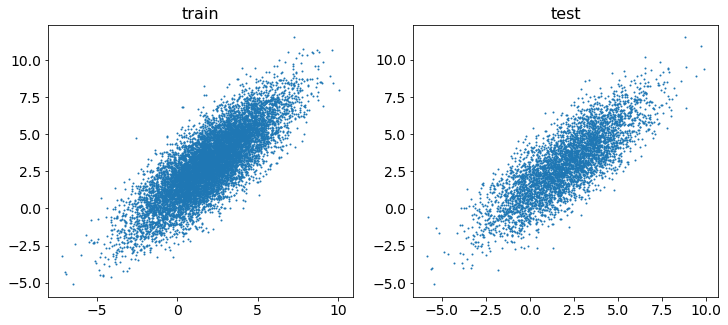

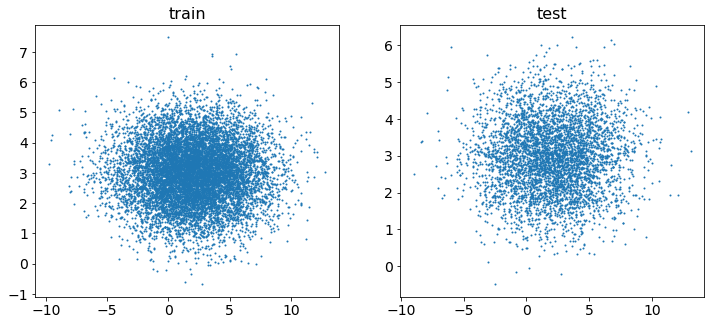

In [5]:
COUNT = 15000

train_data, test_data = generate_2d_data(COUNT, mode="multivariate")
visualize_2d_data(train_data, test_data)

train_data, test_data = generate_2d_data(COUNT, mode="univariate")
visualize_2d_data(train_data, test_data)


Будем рассматривать 2 случая.
1) Матрица ковариации диагональная
2) Матрица ковариации недиагональная

В качестве функционала будем оптимизировать ELBO
$$
    \mathcal{L}(\boldsymbol{\phi}, \boldsymbol{\theta}) = \mathbb{E}_{q(\mathbf{z} | \mathbf{x}, \boldsymbol{\phi})} \log p(\mathbf{x} | \mathbf{z}, \boldsymbol{\theta}) - KL (q(\mathbf{z} | \mathbf{x}, \boldsymbol{\phi}) || p(\mathbf{z})).
$$


In [7]:
def get_normal_KL(mean_1, log_std_1, mean_2=None, log_std_2=None):
    """
    This function return the value of KL(p1 || p2),
    p1 = Normal(mean_1, exp(log_std_1)),
    p2 = Normal(mean_2, exp(log_std_2) ** 2).
    If mean_2 and log_std_2 are None values,  use standard normal distribution.
    """
    if mean_2 is None:
        mean_2 = torch.zeros_like(mean_1)
    if log_std_2 is None:
        log_std_2 = torch.zeros_like(log_std_1)

    sigma_1 = torch.exp(log_std_1)
    sigma_2 = torch.exp(log_std_2)

    out = torch.log(sigma_2 / sigma_1)
    #  print(out)
    out += (sigma_1**2 + (mean_1 - mean_2) ** 2) / (2 * (sigma_2**2))
    out -= 1 / 2

    return out

    # ====

In [9]:
def get_normal_nll(x, mean, log_std):
    """
    This function return the negative log likelihood log p(x),
    p(x) = Normal(x | mean, exp(log_std))
    """
    sigma = torch.exp(log_std)

    out = (((x - mean) / sigma) ** 2) / 2
    out += log_std
    out += torch.log(torch.sqrt(torch.tensor(2 * torch.pi)))

    return out

In [10]:
class FullyConnectedMLP(nn.Module):
    def __init__(self, input_shape, hiddens, output_shape):
        assert isinstance(hiddens, list)
        super().__init__()
        self.input_shape = (input_shape,)
        self.output_shape = (output_shape,)
        self.hiddens = hiddens

        model_hidden = []
        n_layers = len(hiddens) - 1

        self.linear1 = torch.nn.Linear(input_shape, self.hiddens[0])
        self.relu = torch.nn.ReLU(True)

        for i in range(0, n_layers - 1):
            layer = nn.Sequential(
                torch.nn.Linear(self.hiddens[i], self.hiddens[i + 1]), nn.ReLU(True)
            )
            model_hidden.append(layer)

        self.casual_list = nn.ModuleList(model_hidden)
        self.outLinear = nn.Linear(self.hiddens[-1], self.output_shape[0])

        self.net = nn.Sequential(
            self.linear1, self.relu, *self.casual_list, self.outLinear
        )

    def forward(self, x):
        out = self.net(x)
        return out

In [12]:
class VAE2d(nn.Module):
    def __init__(self, n_in, n_latent, enc_hidden_sizes, dec_hidden_sizes):
        assert isinstance(enc_hidden_sizes, list)
        assert isinstance(dec_hidden_sizes, list)
        super().__init__()
        self.n_latent = n_latent

        self.encoder = FullyConnectedMLP(n_in, enc_hidden_sizes, self.n_latent * 2)
        self.decoder = FullyConnectedMLP(n_latent, dec_hidden_sizes, n_in * 2)

    def prior(self, n):
        m = torch.distributions.multivariate_normal.MultivariateNormal(
            torch.zeros(self.n_latent), covariance_matrix=torch.eye(self.n_latent)
        )
        samples = m.sample((n,)).squeeze(1)

        return samples

    def forward(self, x):
        bs = x.size()[0]

        mu_z, log_std_z = self.encoder.forward(x).chunk(2, dim=1)

        samples = self.prior(bs)

        samples = samples * torch.exp(log_std_z)
        samples += mu_z

        mu_x, log_std_x = self.decoder.forward(samples).chunk(2, dim=1)

        return mu_z, log_std_z, mu_x, log_std_x

    def loss(self, x):
        mu_z, log_std_z, mu_x, log_std_x = self(x)

        bs = x.size()[0]

        mu_z, log_std_z, mu_x, log_std_x = self.forward(x)
        recon_loss = get_normal_nll(x, mu_x, log_std_x).sum()
        kl_loss = get_normal_KL(mu_z, log_std_z).sum()

        return {
            "elbo_loss": recon_loss + kl_loss,
            "recon_loss": recon_loss,
            "kl_loss": kl_loss,
        }

    def sample(self, n, sample_from_decoder=True):
        with torch.no_grad():
            samples = self.prior(n)
            out = self.decoder.forward(samples)
            mu_x, log_std_x = self.decoder.forward(samples).chunk(2, dim=1)
            # print(mu_x, log_std_x)

            if sample_from_decoder:
                std_x = torch.exp(log_std_x)
                data = []
                for i in range(n):
                    m = torch.distributions.multivariate_normal.MultivariateNormal(
                        mu_x[i], covariance_matrix=torch.eye(2) * std_x[i]
                    )
                    z = m.sample((1,)).squeeze(1)
                    data.append(z)

                z = torch.cat(data)
            else:
                z = mu_x

        return z.cpu().numpy()

In [14]:
def solve_task(
    train_data, test_data, model, batch_size, epochs, lr, use_cuda=True, use_tqdm=False
):
    train_loader = data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
    test_loader = data.DataLoader(test_data, batch_size=batch_size)

    train_losses, test_losses = train_model(
        model,
        train_loader,
        test_loader,
        epochs=epochs,
        lr=lr,
        use_cuda=use_cuda,
        use_tqdm=use_tqdm,
        loss_key="elbo_loss",
    )

    samples_noise = model.sample(3000, sample_from_decoder=True)
    samples_nonoise = model.sample(3000, sample_from_decoder=False)

    for key, value in test_losses.items():
        print("{}: {:.4f}".format(key, value[-1]))

    plot_training_curves(train_losses, test_losses)
    visualize_2d_samples(samples_noise, title="Samples with Decoder Noise")
    visualize_2d_samples(samples_nonoise, title="Samples without Decoder Noise")

In [15]:
ENC_HIDDEN_SIZES = [128, 128]
DEC_HIDDEN_SIZES = [128, 128]
BATCH_SIZE = 32
EPOCHS = 7
LR = 3e-3

COUNT = 10000

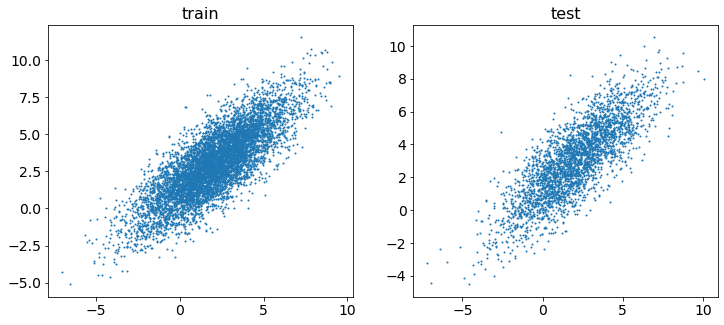

elbo_loss: 129.7185
recon_loss: 98.7928
kl_loss: 30.9256


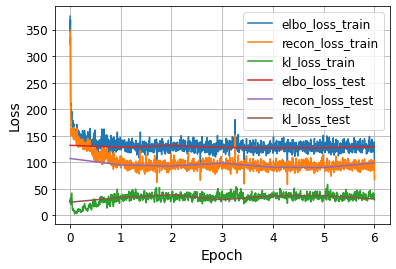

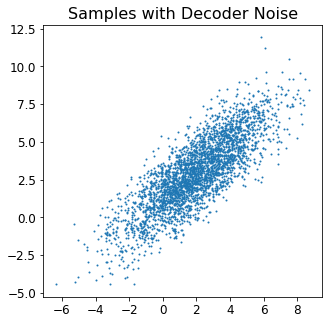

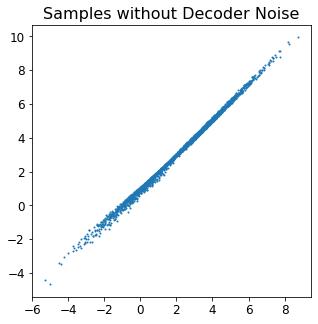

In [16]:
train_data, test_data = generate_2d_data(COUNT, mode="multivariate")
visualize_2d_data(train_data, test_data)

model = VAE2d(2, 2, ENC_HIDDEN_SIZES, DEC_HIDDEN_SIZES)
solve_task(train_data, test_data, model, BATCH_SIZE, EPOCHS, LR, use_cuda=False)

In [17]:
def get_latent_stats(model, test_data, use_cuda=False, batch_size=3000):
    batch = next(iter(data.DataLoader(test_data, batch_size=batch_size, shuffle=True)))
    if use_cuda:
        batch = batch.cuda()

    with torch.no_grad():
        mu_z, log_std_z = model(batch)[:2]

    mu_z = mu_z.cpu().numpy()
    std_z = log_std_z.exp().cpu().numpy()

    return mu_z, std_z

In [18]:
mu_z, std_z = get_latent_stats(model, test_data)

print("mu_z = ", mu_z.mean(axis=0), "+-", mu_z.std(axis=0))
print("std_z = ", std_z.mean(axis=0), "+-", std_z.std(axis=0))

mu_z =  [ 0.07597872 -0.09188083] +- [0.8977277  0.07557186]
std_z =  [0.3769467 1.020174 ] +- [0.03710181 0.05004374]


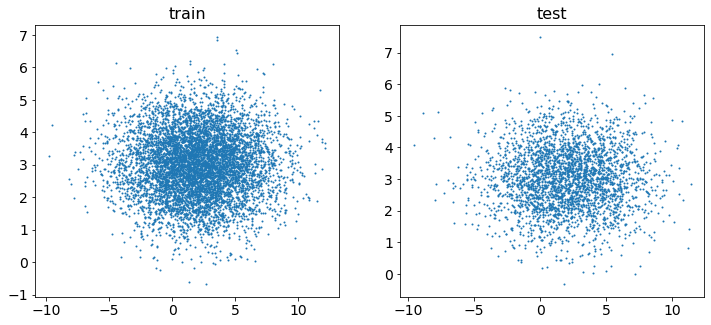

elbo_loss: 126.9124
recon_loss: 126.1922
kl_loss: 0.7202


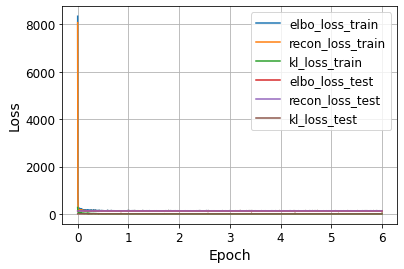

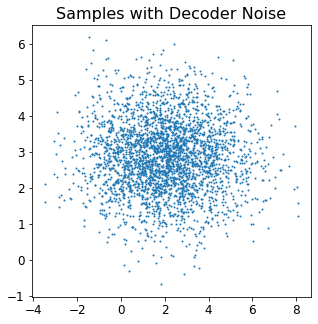

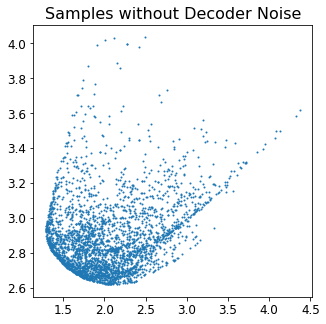

In [19]:
train_data, test_data = generate_2d_data(COUNT, mode="univariate")
visualize_2d_data(train_data, test_data)

model = VAE2d(2, 2, ENC_HIDDEN_SIZES, DEC_HIDDEN_SIZES)
solve_task(train_data, test_data, model, BATCH_SIZE, EPOCHS, LR, use_cuda=False)

In [20]:
mu_z, std_z = get_latent_stats(model, test_data, use_cuda=False)

print("mu_z = ", mu_z.mean(axis=0), "+-", mu_z.std(axis=0))
print("std_z = ", std_z.mean(axis=0), "+-", std_z.std(axis=0))

mu_z =  [-0.02053695  0.0073093 ] +- [0.09978612 0.03378068]
std_z =  [0.9451741 0.9608219] +- [0.09066039 0.05777203]


## VAE on CIFAR10 data 

Теперь рассмотрим модель вариационного автокодировщика на данных CIFAR10

In [21]:
!gdown --id 1FZcV8Mm91fiXm2jFnB0jvK5ROyHdJFvj

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1FZcV8Mm91fiXm2jFnB0jvK5ROyHdJFvj
To: /content/cifar10.pkl
100% 185M/185M [00:04<00:00, 45.9MB/s]


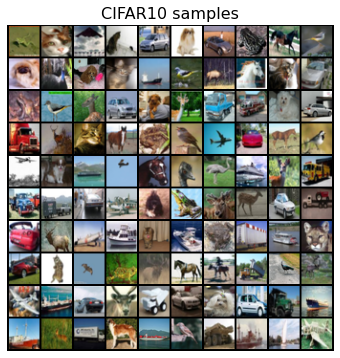

In [22]:
train_data, test_data = load_pickle("cifar10.pkl", flatten=False, binarize=False)
visualize_images(train_data, "CIFAR10 samples")

In [23]:
class ConvEncoder(nn.Module):
    def __init__(self, input_shape, n_latent):
        super().__init__()
        self.input_shape = input_shape
        self.n_latent = n_latent

        self.conv1 = nn.Conv2d(self.input_shape, 32, (3, 3))
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.conv3 = nn.Conv2d(64, 128, 3)
        self.conv4 = nn.Conv2d(128, 256, 3)
        self.fc = nn.Linear(147456, 2 * self.n_latent)

        self.net = nn.Sequential(
            self.conv1,
            nn.ReLU(True),
            self.conv2,
            nn.ReLU(True),
            self.conv3,
            nn.ReLU(True),
            self.conv4,
        )

    def forward(self, x):
        self.out_conv = self.net(x)
        self.flat = torch.flatten(self.out_conv, start_dim=1)
        out = self.fc(self.flat)

        mu, log_std = out.chunk(2, dim=1)
        return mu, log_std


class ConvDecoder(nn.Module):
    def __init__(self, n_latent, output_shape):
        super().__init__()
        self.n_latent = n_latent
        self.output_shape = output_shape

        self.base_size = (128, output_shape[1] // 8, output_shape[2] // 8)

        self.fc = nn.Linear(self.n_latent, 147456)
        self.conv1 = nn.ConvTranspose2d(256, 128, 3)
        self.conv2 = nn.ConvTranspose2d(128, 64, 3)
        self.conv3 = nn.ConvTranspose2d(64, 32, 3)
        self.conv4 = nn.ConvTranspose2d(32, 3, 3)

        self.net = nn.Sequential(
            self.conv1,
            nn.ReLU(True),
            self.conv2,
            nn.ReLU(True),
            self.conv3,
            nn.ReLU(True),
            self.conv4,
        )

    def forward(self, z):
        batch_size = z.size()[0]

        out_linear = self.fc(z)
        out_reshaped = out_linear.reshape((batch_size, 256, 24, 24))
        out = self.net(out_reshaped)

        return out

In [24]:
class ConvVAE(nn.Module):
    def __init__(self, input_shape, n_latent, beta=1):
        super().__init__()
        assert len(input_shape) == 3

        self.input_shape = input_shape
        self.n_latent = n_latent
        self.beta = beta

        self.encoder = ConvEncoder(self.input_shape[0], self.n_latent)
        self.decoder = ConvDecoder(self.n_latent, self.input_shape)

    def prior(self, n, use_cuda=True):
        m = torch.distributions.multivariate_normal.MultivariateNormal(
            torch.zeros(self.n_latent), covariance_matrix=torch.eye(self.n_latent)
        )
        z = m.sample((n,)).squeeze(1)

        if use_cuda:
            z = z.cuda()
        return z

    def forward(self, x):
        bs = x.size()[0]

        out_enc = self.encoder.forward(x)
        mu_z, log_std_z = out_enc

        z_star = self.prior(bs) * torch.exp(log_std_z)
        z_star += mu_z

        x_recon = self.decoder.forward(z_star)
        return mu_z, log_std_z, x_recon

    def loss(self, x):
        mu_z, log_std_z, x_recon = self.forward(x)

        kl_loss = get_normal_KL(mu_z, log_std_z).sum()
        sigma = torch.eye(32)
        sigma = sigma.to("cuda:0")
        recon_loss = get_normal_nll(x, x_recon, sigma).sum()

        return {
            "elbo_loss": recon_loss + self.beta * kl_loss,
            "recon_loss": recon_loss,
            "kl_loss": kl_loss,
        }

    def sample(self, n):
        with torch.no_grad():
            z = self.prior(n)
            x_recon = self.decoder.forward(z)

            samples = torch.clamp(x_recon, -1, 1)
        return samples.cpu().numpy() * 0.5 + 0.5

  0%|          | 0/12 [00:00<?, ?it/s]

elbo_loss: 385486.4485
recon_loss: 381601.0939
kl_loss: 7770.7078


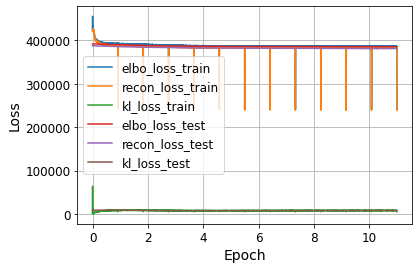

In [26]:
BATCH_SIZE = 128
EPOCHS = 12
LR = 3e-4
N_LATENS = 1024
BETA = 0.5

centered_train_data = train_data * 2 - 1
centered_test_data = test_data * 2 - 1

train_loader = data.DataLoader(centered_train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = data.DataLoader(centered_test_data, batch_size=BATCH_SIZE)

model = ConvVAE((3, 32, 32), N_LATENS, BETA)


train_losses, test_losses = train_model(
    model,
    train_loader,
    test_loader,
    epochs=EPOCHS,
    lr=LR,
    loss_key="elbo_loss",
    use_tqdm=True,
    use_cuda=USE_CUDA,
)
for key, value in test_losses.items():
    print("{}: {:.4f}".format(key, value[-1]))
plot_training_curves(train_losses, test_losses)

Теперь посмотрим на результаты. Изобразим следующие картины

1) Сэмплы новых изображений из модели. По факту это семплы латентных состояний из прайора и примененный к ним декодер

2) Реконструкции изображений, то есть применение энкодера и декодера к нашему изображению из трейна

3) Интерполяции. Применение декодера к двум картинкам, чтобы получить их скрытые состояния, а затем применим декодер к скрытому состоянию, которое будет лежать между скрытыми состояниями изначальных изображений. 


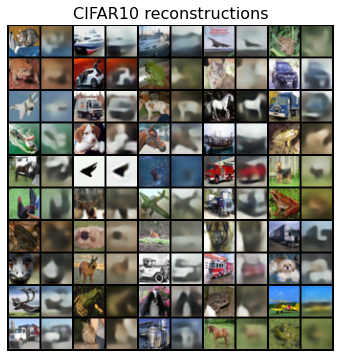

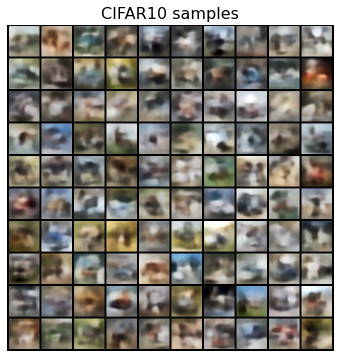

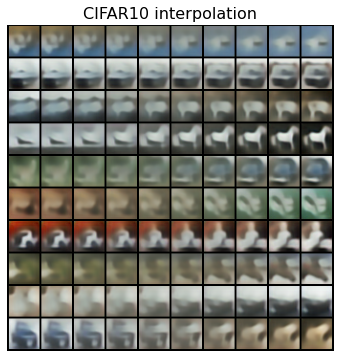

In [27]:
samples = model.sample(100)

x = next(iter(test_loader))[:50]

if USE_CUDA:
    x = x.cuda()

with torch.no_grad():
    z, _ = model.encoder(x)
    x_recon = torch.clamp(model.decoder(z), -1, 1)
reconstructions = torch.stack((x, x_recon), dim=1).view(-1, 3, 32, 32) * 0.5 + 0.5
reconstructions = reconstructions.cpu().numpy()

x = next(iter(test_loader))[:20].cuda()
with torch.no_grad():
    z, _ = model.encoder(x)
    z1, z2 = z.chunk(2, dim=0)
    interps = [
        model.decoder(z1 * (1 - alpha) + z2 * alpha) for alpha in np.linspace(0, 1, 10)
    ]
    interps = torch.stack(interps, dim=1).view(-1, 3, 32, 32)
    interps = torch.clamp(interps, -1, 1) * 0.5 + 0.5
interps = interps.cpu().numpy()

show_samples(reconstructions, "CIFAR10 reconstructions")
show_samples(samples, "CIFAR10 samples")
show_samples(interps, "CIFAR10 interpolation")

Видно, что интерполяции действительно переводят одно изображение в другое, реконструкции немного замыливают, а сэмплы в целом имеют какие-то очертания, но довольно размытые. Кажется связано это со слабой моделью, но тем не менее ее работа имеет явные смысловые очертания